**Explore and cluster the neighborhoods in Toronto. You can decide to work with only boroughs that contain the word Toronto and then replicate the same analysis we did to the New York City data.** 

In [1]:
#!conda install -c conda-forge geopy --yes

In [2]:
import pandas as pd 
import wikipedia as wp
from bs4 import BeautifulSoup
import folium 
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
import numpy as np # library to handle data in a vectorized manner
import json # library to handle JSON files
from sklearn.cluster import KMeans
from ipywidgets import *

**Reading HTML Page**

In [3]:
html = wp.page("List of postal codes of Canada: M").html().encode("UTF-8")

**Create DataFrame from Wikipedia HTML Page**

In [4]:
df = pd.read_html(html, header = 0)[0]

In [5]:
df.shape

(288, 3)

**Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.**

In [6]:
df = df[df.Borough != 'Not assigned']

In [7]:
df = df.groupby(['Postcode', 'Borough'])['Neighbourhood'].apply(list).apply(lambda x:', '.join(x)).to_frame().reset_index()

In [8]:
for index, row in df.iterrows():
    if row['Neighbourhood'] == 'Not assigned':
        row['Neighbourhood'] = row['Borough']

In [9]:
import requests
import io

In [10]:
url="http://cocl.us/Geospatial_data"
geo_data=requests.get(url).content
df_geo=pd.read_csv(io.StringIO(geo_data.decode('utf-8')))

**Get the latitude and longitude coordinates of a given postal code & Map with Postal code of Canada Dataframe**

In [11]:
df_geo.columns = ['Postcode', 'Latitude', 'Longitude']
df = pd.merge(df_geo, df, on='Postcode')

**Reorder Columns of above dataframe**

In [12]:
df = df[['Postcode', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude']]

In [13]:
df.columns

Index(['Postcode', 'Borough', 'Neighbourhood', 'Latitude', 'Longitude'], dtype='object')

In [14]:
df.shape

(103, 5)

**Display Map of Torronto**

**Using the geopy library, obtain the latitude and longitude values for Toronto**

In [15]:
address = 'Toronto, ON, Canada'

geolocator = Nominatim(user_agent="to_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto, ON, Canada are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto, ON, Canada are 43.653963, -79.387207.


In [16]:

map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
map_toronto

In [17]:
# df_toronto_loc.Borough.str.contains('Toronto') -> TRUE or FALSE output
new_df_toronto_loc = df[df.Borough.str.contains('Toronto')]
new_df_toronto_loc.head(10)

,Postcode,Borough,Neighbourhood,Latitude,Longitude
37,M4E,East Toronto,The Beaches,43.676357,-79.293031
41,M4K,East Toronto,"The Danforth West, Riverdale",43.679557,-79.352188
42,M4L,East Toronto,"The Beaches West, India Bazaar",43.668999,-79.315572
43,M4M,East Toronto,Studio District,43.659526,-79.340923
44,M4N,Central Toronto,Lawrence Park,43.728020,-79.388790
45,M4P,Central Toronto,Davisville North,43.712751,-79.390197
46,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
47,M4S,Central Toronto,Davisville,43.704324,-79.388790
48,M4T,Central Toronto,"Moore Park, Summerhill East",43.689574,-79.383160
49,M4V,Central Toronto,"Deer Park, Forest Hill SE, Rathnelly, South Hi...",43.686412,-79.400049


In [18]:
new_df_toronto_loc.shape

(38, 5)

In [22]:
# Adding markers to map
for lat, lng, borough, neighbourhood in zip(new_df_toronto_loc['Latitude'], 
                                            new_df_toronto_loc['Longitude'],
                                            new_df_toronto_loc['Borough'],
                                            new_df_toronto_loc['Neighbourhood']):
    label = '{} - {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_toronto)  
    




**Explore further the Neighbourhoods by using the Foursquare API. This is started by defining Foursquare Credentials and Version**

In [20]:
CLIENT_ID = 'PSHOLQXLVECKGZUS2SXIK5V41SPUO3TWGGJ20A34HQRDPFVN' # your Foursquare ID
CLIENT_SECRET = 'BKBUPX3RLBRS5MO5L1UVTZRL5HPDRVCIR51WFCYBLYMDKJEK' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: PSHOLQXLVECKGZUS2SXIK5V41SPUO3TWGGJ20A34HQRDPFVN
CLIENT_SECRET:BKBUPX3RLBRS5MO5L1UVTZRL5HPDRVCIR51WFCYBLYMDKJEK


**Initial Exploration of a Single Neighbourhood - Central Toronto**

In [26]:
toronto_df = new_df_toronto_loc.reset_index().drop('index', axis = 1)

In [27]:
toronto_df.loc[4, 'Borough']

'Central Toronto'

In [28]:
central_toronto4_lat = toronto_df.loc[4, 'Latitude']
central_toronto4_long = toronto_df.loc[4, 'Longitude']
central_toronto4_borough = toronto_df.loc[4, 'Borough']
central_toronto4_postcode = toronto_df.loc[4, 'Postcode']

print('The latitude and longitude values of the {} borough with postcode {}, are {}, {}.'.format(central_toronto4_borough,
                                                                                                 central_toronto4_postcode,
                                                                                                 central_toronto4_lat,
                                                                                                 central_toronto4_long))

The latitude and longitude values of the Central Toronto borough with postcode M4N, are 43.7280205, -79.3887901.


In [29]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    central_toronto4_lat, 
    central_toronto4_long, 
    radius, 
    LIMIT)

# displays URL
url

'https://api.foursquare.com/v2/venues/explore?&client_id=PSHOLQXLVECKGZUS2SXIK5V41SPUO3TWGGJ20A34HQRDPFVN&client_secret=BKBUPX3RLBRS5MO5L1UVTZRL5HPDRVCIR51WFCYBLYMDKJEK&v=20180605&ll=43.7280205,-79.3887901&radius=500&limit=100'

In [30]:
foursquare_response = requests.get(url).json()

In [32]:
 #function that extracts the category of the venue
def category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [33]:
tor_venues = foursquare_response['response']['groups'][0]['items']
    
nearby_venues = json_normalize(tor_venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

In [34]:
nearby_venues

,name,categories,lat,lng
0,Lawrence Park Ravine,Park,43.726963,-79.394382
1,The Photo School – Toronto,Photography Studio,43.730429,-79.388767
2,Zodiac Swim School,Swim School,43.728532,-79.382860
3,TTC Bus #162 - Lawrence-Donway,Bus Line,43.728026,-79.382805


**Exploring All Neighborhoods in Toronto By repeating above process**

In [35]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [36]:
toronto_venues = getNearbyVenues(names=toronto_df['Neighbourhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude']
                                  )

The Beaches
The Danforth West, Riverdale
The Beaches West, India Bazaar
Studio District
Lawrence Park
Davisville North
North Toronto West
Davisville
Moore Park, Summerhill East
Deer Park, Forest Hill SE, Rathnelly, South Hill, Summerhill West
Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Roselawn
Forest Hill North, Forest Hill West
The Annex, North Midtown, Yorkville
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The 

In [37]:
toronto_venues.head(10)

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,The Beaches,43.676357,-79.293031,Glen Manor Ravine,43.676821,-79.293942,Trail
1,The Beaches,43.676357,-79.293031,The Big Carrot Natural Food Market,43.678879,-79.297734,Health Food Store
2,The Beaches,43.676357,-79.293031,Grover Pub and Grub,43.679181,-79.297215,Pub
3,The Beaches,43.676357,-79.293031,Glen Stewart Ravine,43.676300,-79.294784,Other Great Outdoors
4,The Beaches,43.676357,-79.293031,Upper Beaches,43.680563,-79.292869,Neighborhood
5,"The Danforth West, Riverdale",43.679557,-79.352188,Pantheon,43.677621,-79.351434,Greek Restaurant
6,"The Danforth West, Riverdale",43.679557,-79.352188,Dolce Gelato,43.677773,-79.351187,Ice Cream Shop
7,"The Danforth West, Riverdale",43.679557,-79.352188,MenEssentials,43.677820,-79.351265,Cosmetics Shop
8,"The Danforth West, Riverdale",43.679557,-79.352188,Cafe Fiorentina,43.677743,-79.350115,Italian Restaurant
9,"The Danforth West, Riverdale",43.679557,-79.352188,La Diperie,43.677530,-79.352295,Ice Cream Shop


# Explore and cluster the neighborhoods in Toronto

In [38]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix = "", prefix_sep = "")

In [39]:
# add neighborhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_venues['Neighbourhood']

In [40]:
# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

In [41]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.03,0.0,...,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.01,0.0,0.000000
1,Berczy Park,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.017857,0.0,0.0,0.00,0.0,0.000000
2,"Brockton, Exhibition Place, Parkdale Village",0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.043478
3,Business Reply Mail Processing Centre 969 Eastern,0.0,0.0000,0.0000,0.0000,0.000,0.0000,0.000,0.00,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000
4,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.0,0.0625,0.0625,0.0625,0.125,0.1875,0.125,0.00,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.000000


In [42]:
kclusters = 3

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

**Clustering Visualization**

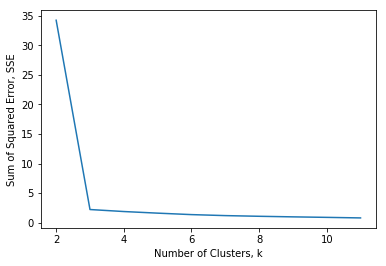

In [44]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
# SSE is initialize with empty values
# n_clusters is the "k" 
sse = {}
for n_cluster1 in range(2, 12):
    kmeans1 = KMeans(n_clusters = n_cluster1, max_iter = 1000).fit(toronto_grouped_clustering)
    toronto_grouped_clustering["clusters"] = kmeans1.labels_
    
    # The inertia is the sum of distances of samples to their closest cluster centre
    sse[n_cluster1] = kmeans1.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of Clusters, k")
plt.ylabel("Sum of Squared Error, SSE")
plt.show()

In [46]:
toronto_merged = df

In [47]:
toronto_merged = toronto_merged[toronto_merged.Postcode != 'M5N']

In [48]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending = False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [49]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

In [50]:
neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [51]:
# match/merge Toronto data with latitude/longitude for each neighborhood
toronto_merged_latlong = toronto_merged.join(neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

In [52]:
toronto_clusters = toronto_merged_latlong

In [53]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_clusters['Latitude'], toronto_clusters['Longitude'], toronto_clusters['Neighbourhood'], toronto_clusters['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        
        fill=True,
        
        fill_opacity=0.7).add_to(map_clusters)



# Cluster 1

In [54]:
toronto_clusters.loc[toronto_clusters['Cluster Labels'] == 0, toronto_clusters.columns[[1] + list(range(5, toronto_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
44,Central Toronto,0.0,Photography Studio,Park,Bus Line,Swim School,Dive Bar,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant,Electronics Store
50,Downtown Toronto,0.0,Park,Playground,Trail,Building,Yoga Studio,Dive Bar,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
64,Central Toronto,0.0,Park,Trail,Jewelry Store,Sushi Restaurant,Yoga Studio,Dog Run,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space


# Cluster 2

In [55]:
toronto_clusters.loc[toronto_clusters['Cluster Labels'] == 1, toronto_clusters.columns[[1] + list(range(5, toronto_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
37,East Toronto,1.0,Health Food Store,Neighborhood,Other Great Outdoors,Trail,Pub,Eastern European Restaurant,Dog Run,Doner Restaurant,Donut Shop,Dumpling Restaurant
41,East Toronto,1.0,Greek Restaurant,Coffee Shop,Ice Cream Shop,Italian Restaurant,Furniture / Home Store,Yoga Studio,Bookstore,Brewery,Bubble Tea Shop,Caribbean Restaurant
42,East Toronto,1.0,Pet Store,Sushi Restaurant,Ice Cream Shop,Italian Restaurant,Fish & Chips Shop,Fast Food Restaurant,Liquor Store,Movie Theater,Park,Pizza Place
43,East Toronto,1.0,Café,Coffee Shop,Gastropub,Italian Restaurant,American Restaurant,Bakery,Yoga Studio,Convenience Store,Seafood Restaurant,Sandwich Place
45,Central Toronto,1.0,Clothing Store,Gym / Fitness Center,Gym,Grocery Store,Park,Hotel,Breakfast Spot,Sandwich Place,Food & Drink Shop,Asian Restaurant
46,Central Toronto,1.0,Sporting Goods Shop,Coffee Shop,Clothing Store,Yoga Studio,Dessert Shop,Spa,Burger Joint,Metro Station,Mexican Restaurant,Salon / Barbershop
47,Central Toronto,1.0,Pizza Place,Sandwich Place,Dessert Shop,Café,Italian Restaurant,Coffee Shop,Sushi Restaurant,Gym,Deli / Bodega,Seafood Restaurant
49,Central Toronto,1.0,Pub,Coffee Shop,Fried Chicken Joint,American Restaurant,Restaurant,Sushi Restaurant,Bagel Shop,Sports Bar,Supermarket,Pizza Place
51,Downtown Toronto,1.0,Coffee Shop,Restaurant,Café,Flower Shop,Italian Restaurant,Bakery,Pub,Pizza Place,Pet Store,Breakfast Spot
52,Downtown Toronto,1.0,Coffee Shop,Japanese Restaurant,Sushi Restaurant,Gay Bar,Restaurant,Pub,Bubble Tea Shop,Café,Men's Store,Mediterranean Restaurant


# Cluster 3

In [56]:
toronto_clusters.loc[toronto_clusters['Cluster Labels'] == 2, toronto_clusters.columns[[1] + list(range(5, toronto_clusters.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
48,Central Toronto,2.0,Playground,Trail,Summer Camp,Yoga Studio,Dive Bar,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant


# Conclusion

**After Observing cluster 1 we can conclude that this cluster includes Park,PlayGround,Photography with Central Toronto and Downtown toronto Area.**

**After Observing cluster 2 we can conclude that this cluster includes stores and shops with East Toronto and Downtown toronto Area.**

**After Observing cluster 3 we can conclude that this cluster includes PlayGround,Trail with Central Toronto  Area.**